# <u>Group Project 2</u>

### Objective
In this project, we would like to estimate the announcement effect of Volcker Rule (new banking regulation in US) on US banks. More specifically, analyze at least:

- Did the banks decrease their trading assets after the announcement of the new regulation?
- If they responded to the regulation, which banks responded most and which banks least? Why?
- Remember robustness, and how should banks or regulators use these results?

### Variable Description

- <strong>rssd9001</strong>: *Banking holding company code*
- <strong>rssd9999</strong>: *time*
- <strong>bhc_avgtradingratio</strong>: *Trading asset ratio*, ratio of trading assets to total assets
- <strong>treat_3_b_avg</strong>: *Affected BHC*, dummy variable takes a value of one if the average trading asset ratio during the pre-DFA period (Q3 2004 - Q2 2009) was equal to or larger than 3%, and zero otherwise.
- <strong>after_DFA_1</strong>: *After DFA dummy*, dummy variable that equals one for all quarters between the third quarter of 2010 and the second quarter of 2015, and zero for all quarters from the third quarter of 2004 to the second quarter of 2009
- <strong>dep_roa1</strong>: *Return on assets*, net operating income divided by average total assets
- <strong>dep_leverage</strong>: *Leverage ratio*, average equity divided by average total assets
- <strong>dep_lnassets</strong>: *Total assets*, natural logarithm of total assets 
- <strong>dep_creditrisk_total3</strong>: *Non-performing loan ratio*, past due and non-accrual loans divided by total loans
- <strong>dep_cir</strong>: *Cost-income ratio*, operating expenses divided by total income
- <strong>dep_depositratio</strong>: *Deposit ratio*, average deposits divided by averagetotal assets
- <strong>dep_loans_REratio</strong>: *Real estate loan ratio*, loans secured by real estate divided by total loans
- <strong>dep_liquidity</strong>: *Liquidity ratio*, cash and balances at other depository institutions divided by total assets
- <strong>dep_cpp_bankquarter</strong>: *CPP recipient indicator*, capital Purchase Program indicator variable takes one if the bank is a current recipient of CPP funds in a given quarter, and zero otherwise.



In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS
import scipy.stats as stats

#################################################################################################

def ctl_trt_diff(df):
    """
    Calculates the Differences in the Mean and Standard Deviation of the Control and Treatment Group
    """
    
    int_var = [
        "dep_lnassets",
        "dep_leverage",
        "dep_roa1",
        "dep_liquidity",
        "dep_depositratio",
        "dep_loans_REratio",
        "dep_cir",
        "dep_creditrisk_total3", # added in CV
        "dep_cpp_bankquarter"
    ]

    # Calculate the group means and standard deviation
    group_mean = df.groupby("treat_3_b_avg").mean(numeric_only=True)
    group_std = df.groupby("treat_3_b_avg").std(numeric_only=True)
    
    # Extract Control result
    ctl_mean = group_mean[group_mean.index == 0]
    ctl_mean = ctl_mean[int_var].reset_index().drop(columns="treat_3_b_avg")
    ctl_sd = group_std[group_std.index == 0]
    ctl_sd = ctl_sd[int_var].reset_index().drop(columns="treat_3_b_avg")
    
    control = pd.concat([ctl_mean, ctl_sd])
    control = control.transpose()
    control.columns = pd.MultiIndex.from_tuples([('Control', 'Mean'), ('Control', 'SD')])

    # Extract Treatment result
    trt_mean = group_mean[group_mean.index == 1]
    trt_mean = trt_mean[int_var].reset_index().drop(columns="treat_3_b_avg")
    trt_sd = group_std[group_std.index == 1]
    trt_sd = trt_sd[int_var].reset_index().drop(columns="treat_3_b_avg")
    
    treatment = pd.concat([trt_mean, trt_sd])
    treatment = treatment.transpose()
    treatment.columns = pd.MultiIndex.from_tuples([('Treatment', 'Mean'), ('Treatment', 'SD')])

    # Extract Difference result
    mean_diff = ctl_mean - trt_mean
    sd_diff = ctl_sd - trt_sd
    
    diff = pd.concat([mean_diff, sd_diff])
    diff = diff. transpose()
    diff.columns = pd.MultiIndex.from_tuples([('Difference', 'Mean'), ('Difference', 'SD')])

    # Create a new DataFrame concatenating control, treatment, and diff
    result_df = pd.concat([control, treatment, diff], axis=1)
    
    return result_df
    
#################################################################################################
    
def dataplot(df):
    """
    Plots the graph of bhc_avgtradingratio with respect to time for the Control and Treatment Group
    """
    
    control_df = df[df["treat_3_b_avg"] == 0]
    treatment_df = df[df["treat_3_b_avg"] == 1]
    
    x_control = np.sort(control_df["time"].unique())
    y_control = control_df.groupby("rssd9999").mean(numeric_only=True)["bhc_avgtradingratio"].values
    
    x_treatment = np.sort(treatment_df["time"].unique())
    y_treatment = treatment_df.groupby("rssd9999").mean(numeric_only=True)["bhc_avgtradingratio"].values
    
    plt.plot(x_control, y_control, marker='o', linestyle='-', color='red', label='Control')
    plt.plot(x_treatment, y_treatment, marker='x', linestyle='-', color='blue', label='Treatment')
    plt.axvline(x=max(df[df["after_DFA_1"] == 0]["time"]), color='red', linestyle='dashed', linewidth=2)
    plt.axvline(x=min(df[df["after_DFA_1"] == 1]["time"]), color='red', linestyle='dashed', linewidth=2)
    
    plt.xlabel("Time")
    plt.ylabel("Trading Asset Ratio")
    plt.grid(True)

    # Add a legend outside the graph
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

#################################################################################################
def t_test(df):
    """
    Performs T-tests for each covariate
    """
    
    control_group = df[(df['treat_3_b_avg'] == 0) & (df["rssd9999"] == 20040930)]
    treat_group = df[(df['treat_3_b_avg'] == 1) & (df["rssd9999"] == 20040930)]
    
    print(f"No. of Control: {len(control_group)}, No. of Treatment: {len(treat_group)}")
    
    covariates = [
        'bhc_avgtradingratio', 
        'dep_roa1', 
        'dep_leverage',
        'dep_lnassets',
        'dep_creditrisk_total3',
        'dep_cir','dep_depositratio',
        'dep_loans_REratio',
        'dep_liquidity',
        'dep_cpp_bankquarter'
    ]
    
    results = {}
    
    for covariate in covariates:
        t_stat, p_value = stats.ttest_ind(treat_group[covariate], control_group[covariate])
        results[covariate] = {'t-value': t_stat, 'p-value': p_value}

    return pd.DataFrame(results).transpose()

#################################################################################################   


In [2]:
# Read the data from the CSV file
df = pd.read_csv("DiD_data.csv")


Here, we create a "time" column for data plotting and drop all datasets that contain NA values.

In [3]:
# process time
df['time'] = pd.to_datetime(df['rssd9999'], format='%Y%m%d')

# drop NA values
initial_row_count = df.shape[0]

df.dropna(inplace=True)

final_row_count = df.shape[0]

print(f'Initial No. of rows: {initial_row_count}')
print(f'Final No. of rows: {final_row_count}')
print(f'No. of rows dropped: {initial_row_count - final_row_count}')

df

Initial No. of rows: 81560
Final No. of rows: 40026
No. of rows dropped: 41534


,rssd9001,rssd9999,bhc_avgtradingratio,treat_3_b_avg,after_DFA_1,dep_roa1,dep_leverage,dep_lnassets,dep_creditrisk_total3,dep_cir,dep_depositratio,dep_loans_REratio,dep_liquidity,dep_cpp_bankquarter,time
0,1020180,20040930,0.0,0,0,0.002772,0.081957,15.601202,0.013304,0.463811,0.561805,0.593738,0.024337,0,2004-09-30
1,1020180,20041231,0.0,0,0,0.003045,0.082480,15.630583,0.009732,0.456392,0.557617,0.601763,0.025446,0,2004-12-31
2,1020180,20050331,0.0,0,0,0.002616,0.082074,15.644925,0.011830,0.444011,0.556980,0.600700,0.025153,0,2005-03-31
3,1020180,20050630,0.0,0,0,0.002647,0.081712,15.679702,0.013654,0.433771,0.571642,0.601042,0.023670,0,2005-06-30
4,1020180,20050930,0.0,0,0,0.002867,0.082944,15.661868,0.012456,0.400985,0.577408,0.581438,0.029793,0,2005-09-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40021,3832583,20140331,0.0,0,1,0.006362,0.225532,13.525286,0.008318,0.528542,0.720636,0.001986,0.081983,0,2014-03-31
40022,3832583,20140630,0.0,0,1,0.006616,0.224154,13.519756,0.007821,0.490698,0.724049,0.002048,0.084540,0,2014-06-30
40023,3832583,20140930,0.0,0,1,0.006579,0.226952,13.523643,0.008012,0.469434,0.716915,0.001870,0.075759,0,2014-09-30
40024,3832583,20141231,0.0,0,1,0.006423,0.227009,13.552240,0.008406,0.473358,0.709474,0.001760,0.074139,0,2014-12-31


---

# <u>Propensity Score Matching (PSM)</u>

### Without PSM

In [4]:
nopro_df = df.copy()

nopro_control = nopro_df[nopro_df["treat_3_b_avg"] == 0]
nopro_treatment = nopro_df[nopro_df["treat_3_b_avg"] == 1]

print("No. of Control:", len(nopro_control))
print("No. of Treatment:", len(nopro_treatment))
print("Total No. of Dataset:", len(nopro_df))

diff_df = ctl_trt_diff(nopro_df)
diff_df

No. of Control: 39399
No. of Treatment: 627
Total No. of Dataset: 40026


Control            Treatment           Difference  \
                            Mean        SD       Mean        SD       Mean   
dep_lnassets           13.820476  1.248448  18.243661  2.610865  -4.423185   
dep_leverage            0.091852  0.034937   0.095510  0.048490  -0.003657   
dep_roa1                0.001811  0.004808   0.002024  0.003548  -0.000213   
dep_liquidity           0.049324  0.046740   0.084605  0.088524  -0.035281   
dep_depositratio        0.678902  0.114933   0.318852  0.220648   0.360050   
dep_loans_REratio       0.743319  0.149757   0.406682  0.257637   0.336637   
dep_cir                 0.528123  0.267764   0.590208  0.730347  -0.062086   
dep_creditrisk_total3   0.028362  0.034610   0.026234  0.026962   0.002128   
dep_cpp_bankquarter     0.069291  0.253952   0.066986  0.250197   0.002305   

                                 
                             SD  
dep_lnassets          -1.362417  
dep_leverage          -0.013553  
dep_roa1               0.001260  
dep_liquidity         -0.041785  
dep_depositratio      -0.105715  
dep_loans_REratio     -0.107880  
dep_cir               -0.462583  
dep_creditrisk_total3  0.007648  
dep_cpp_bankquarter    0.003755

In [5]:
t_test(nopro_df)

No. of Control: 783, No. of Treatment: 18


,t-value,p-value
bhc_avgtradingratio,33.068324,9.110721e-152
dep_roa1,0.214336,8.303397e-01
dep_leverage,-1.376366,1.690939e-01
dep_lnassets,14.975957,7.128283e-45
dep_creditrisk_total3,0.782190,4.343349e-01
dep_cir,-0.987957,3.234726e-01
dep_depositratio,-12.376582,2.592506e-32
dep_loans_REratio,-5.269834,1.758049e-07
dep_liquidity,1.185567,2.361459e-01
dep_cpp_bankquarter,NaN,NaN


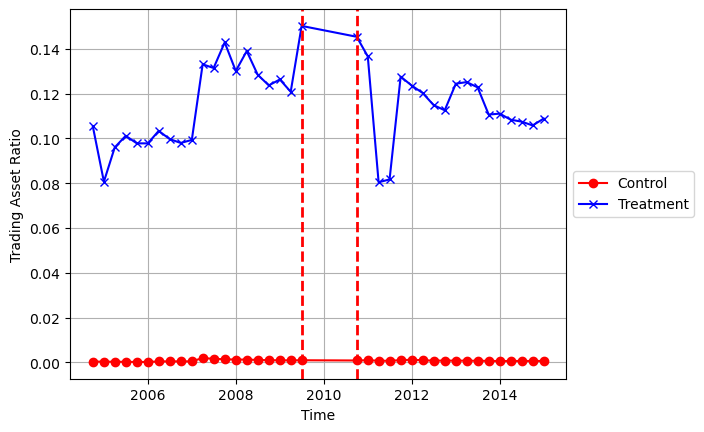

In [6]:
dataplot(nopro_df)

### With PSM

We choose not to include too many quarters and only include those where after_DFA_1 = 0 (pre-announcement). Otherwise, the model gets more precise and PSM doesn't work.

In [7]:
pro_df = df.copy()
pro_df = pro_df[pro_df['after_DFA_1'] == 0]

Then, we calculated the propensity score via logistic regression model for every dataset and append its value in a new column "propensity_scores".

In [8]:
# Logistic Regression Model

# Define predictor variables (features) in X and the binary treatment variable in y
X = pro_df[[
        # "bhc_avgtradingratio", 
        # "after_DFA_1",
        "dep_roa1", 
        "dep_leverage",
        "dep_creditrisk_total3",
        "dep_lnassets", 
        "dep_cir",
        "dep_depositratio",
        "dep_loans_REratio",
        "dep_liquidity",
        "dep_cpp_bankquarter"
    ]]

X = sm.add_constant(X)  # Add a constant (intercept) term

y = pro_df['treat_3_b_avg']  # binary treatment variable (0 or 1)

# Create and fit a logistic regression model to calculate propensity scores
logistic_model = sm.Logit(y, X)
logistic_results = logistic_model.fit()

# Get the predicted probabilities (propensity scores)
propensity_scores = logistic_results.predict()
pro_df["propensity_scores"] = propensity_scores

logistic_results.summary()

Optimization terminated successfully.
         Current function value: 0.037594
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          treat_3_b_avg   No. Observations:                24428
Model:                          Logit   Df Residuals:                    24418
Method:                           MLE   Df Model:                            9
Date:                Fri, 20 Oct 2023   Pseudo R-squ.:                  0.5190
Time:                        16:31:50   Log-Likelihood:                -918.34
converged:                       True   LL-Null:                       -1909.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -9.1772      0.800    -11.471      0.000     -10.745      -7.609
dep_roa1                -17.3937     15.639     -1.112      0.266     -48.046      13.259
dep_leverage              3.1288      1.388      2.254      0.024       0.408       5.850
dep_creditrisk_total3    -5.8443      3.532     -1.655      0.098     -12.767       1.079
dep_lnassets              0.6301      0.035     17.856      0.000       0.561       0.699
dep_cir                  -0.1275      0.322     -0.396      0.692      -0.758       0.503
dep_depositratio         -4.5493      0.420    -10.844      0.000      -5.372      -3.727
dep_loans_REratio        -3.2503      0.351     -9.260      0.000      -3.938      -2.562
dep_liquidity            -4.0133      1.365     -2.941      0.003      -6.688      -1.339
dep_cpp_bankquarter      -0.3395      0.389     -0.873      0.383      -1.102       0.423
=========================================================================================
"""

We identify the first timestamp and use it to identify our control and treatment groups.

In [9]:
min_time_index = pro_df["time"].idxmin()
min_rssd9999 = pro_df.loc[min_time_index, "rssd9999"]

print(f"rssd9999: {min_rssd9999}, time: {pro_df.loc[min_time_index, 'time']}\n")

# Potential Control and Treatment Groups
control_groups = pro_df[(pro_df['treat_3_b_avg'] == 0) & (pro_df["rssd9999"] == min_rssd9999)]
treated_groups = pro_df[(pro_df['treat_3_b_avg'] == 1) & (pro_df["rssd9999"] == min_rssd9999)]

print(f"No. of Identified Controls: {len(control_groups)}, No. of Identified Treatments: {len(treated_groups)}")

# Check that control_groups and treated_groups do not have duplicated banks
# control_groups = control_groups.drop_duplicates()
# treated_groups = treated_groups.drop_duplicates()
# print(len(control_groups), len(treated_groups))

rssd9999: 20040930, time: 2004-09-30 00:00:00

No. of Identified Controls: 783, No. of Identified Treatments: 18


In [10]:
# Number of nearest neighbors to find
n_neighbors = 3

treated_propensity_scores = treated_groups['propensity_scores'].values.reshape(-1, 1)
control_propensity_scores = control_groups['propensity_scores'].values.reshape(-1, 1)

# Initialize and fit the Nearest Neighbors model
nn_model = NearestNeighbors(n_neighbors=n_neighbors)
nn_model.fit(control_propensity_scores)

# Find the indices of the closest control banks for each treated bank
distances, indices = nn_model.kneighbors(treated_propensity_scores)

# Initialize an empty DataFrame to store matched pairs
ctl_list, trt_list = [], []

for i in range(len(treated_groups)):
    # Identifying Treatment Bank
    treatment_bank = treated_groups.iloc[i] 
    trt_list.append(treatment_bank["rssd9001"])    
    
    # Identifying 3 Control Banks that are the closet to the Treatment Bank
    control_indices = indices[i]
    control_banks = control_groups.iloc[control_indices] 
    for control_bhc in control_banks["rssd9001"]:
        ctl_list.append(control_bhc)
        
print(f"No. of Control: {len(ctl_list)}, No. of Treatment: {len(trt_list)}")
print(f"No. of Control & Treatment: {len(ctl_list) + len(trt_list)}")
print(f"No. of Unique Control & Treatment: {len(list(set(ctl_list))) + len(list(set(trt_list)))}")

No. of Control: 54, No. of Treatment: 18
No. of Control & Treatment: 72
No. of Unique Control & Treatment: 43


Since the No. of Control > No. of Treatment and No. of Control & Treatment != No. of Unique Control & Treatment, there are control banks that are selected multiple times, suggesting that they have a higher weight. With ctl_trt_list containing the list of the BHCs of banks belonging in both the Control and Treatment group, let us select their data sets.

In [11]:
pro_control, pro_treatment = pd.DataFrame(), pd.DataFrame()

for bhc in ctl_list:
    pro_control = pd.concat([pro_control, df[df["rssd9001"] == bhc]])
    
for bhc in trt_list:
    pro_treatment = pd.concat([pro_treatment, df[df["rssd9001"] == bhc]])

new_df = pd.concat([pro_control, pro_treatment]).reset_index(drop=True)

print("No. of Control:", len(pro_control))
print("No. of Treatment:", len(pro_treatment))
print("Total No. of Dataset:", len(new_df))
    
diff_df = ctl_trt_diff(new_df)
diff_df

No. of Control: 807
No. of Treatment: 362
Total No. of Dataset: 1169


Control            Treatment           Difference  \
                            Mean        SD       Mean        SD       Mean   
dep_lnassets           16.612222  1.948891  18.505845  2.647945  -1.893624   
dep_leverage            0.104501  0.036022   0.090089  0.019368   0.014412   
dep_roa1                0.003393  0.005121   0.001903  0.003133   0.001490   
dep_liquidity           0.080395  0.069756   0.063929  0.060005   0.016466   
dep_depositratio        0.498561  0.176372   0.354444  0.196752   0.144117   
dep_loans_REratio       0.512269  0.225840   0.478020  0.174506   0.034249   
dep_cir                 0.561323  0.167096   0.563033  0.936205  -0.001710   
dep_creditrisk_total3   0.024542  0.026315   0.033069  0.028369  -0.008527   
dep_cpp_bankquarter     0.074349  0.262501   0.082873  0.276072  -0.008523   

                                 
                             SD  
dep_lnassets          -0.699055  
dep_leverage           0.016654  
dep_roa1               0.001988  
dep_liquidity          0.009751  
dep_depositratio      -0.020380  
dep_loans_REratio      0.051334  
dep_cir               -0.769109  
dep_creditrisk_total3 -0.002054  
dep_cpp_bankquarter   -0.013570

In [12]:
t_test(new_df)

No. of Control: 54, No. of Treatment: 18


,t-value,p-value
bhc_avgtradingratio,8.240557,6.585612e-12
dep_roa1,-0.455137,6.504190e-01
dep_leverage,-2.855977,5.642883e-03
dep_lnassets,1.440597,1.541565e-01
dep_creditrisk_total3,1.922377,5.862840e-02
dep_cir,-3.358150,1.272214e-03
dep_depositratio,-0.227712,8.205341e-01
dep_loans_REratio,-0.183882,8.546379e-01
dep_liquidity,-1.461656,1.483103e-01
dep_cpp_bankquarter,NaN,NaN


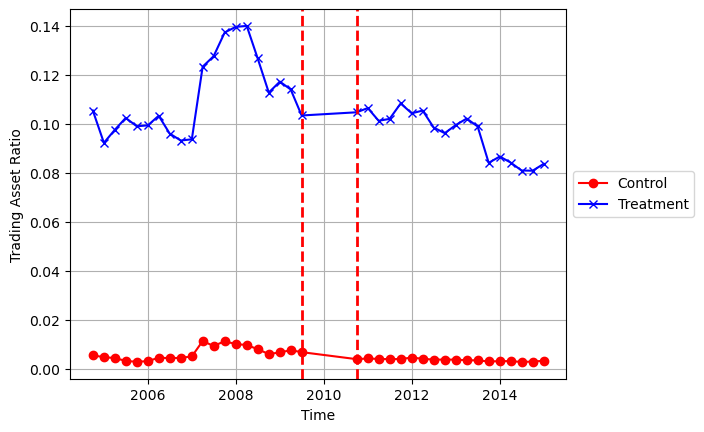

In [13]:
dataplot(new_df)

---

# <u>Difference-in-Differences (DiD) Model</u>

Let us prepare our panel data for running DiD.

In [14]:
# Convert dataframe into panel (this is necessary to use the PanelOLS function)

# Dataset without Propensity Score Matching
nopro_panel_df = df.set_index(['rssd9001', 'rssd9999'])
del nopro_panel_df['time']

pro_panel_df = new_df.set_index(['rssd9001', 'rssd9999'])
del pro_panel_df['time']


### Model 1: Base Model (No PSM)
_Y<sub>i,t</sub> = α + β<sub>1</sub> * ( after_DFA_1<sub>t</sub> ) + β<sub>2</sub> * ( treat_3_b_avg<sub>i</sub> ) + β<sub>3</sub> * ( after_DFA_1<sub>t</sub> * treat_3_b_avg<sub>i</sub> ) + X<sub>i,t</sub> + ε<sub>i,t</sub>_


In [15]:
Y = nopro_panel_df['bhc_avgtradingratio']

interact_term = nopro_panel_df['after_DFA_1'] * nopro_panel_df['treat_3_b_avg']
nopro_panel_df["interact"] = interact_term

X = nopro_panel_df[['after_DFA_1', 'treat_3_b_avg', 'interact', 'dep_roa1', 
                    'dep_leverage', 'dep_lnassets', 'dep_creditrisk_total3', 
                    'dep_cir', 'dep_depositratio', 'dep_loans_REratio', 
                    'dep_liquidity', 'dep_cpp_bankquarter']]
X = sm.add_constant(X)

model = PanelOLS.from_formula('Y ~ X', data=nopro_panel_df)
results = model.fit()

print(results)
print(f"No. of Observations: {len(nopro_panel_df)}")

                          PanelOLS Estimation Summary                           
Dep. Variable:                      Y   R-squared:                        0.5557
Estimator:                   PanelOLS   R-squared (Between):              0.6037
No. Observations:               40026   R-squared (Within):              -0.0398
Date:                Fri, Oct 20 2023   R-squared (Overall):              0.5557
Time:                        16:31:51   Log-likelihood                 1.169e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      4169.7
Entities:                        2428   P-value                           0.0000
Avg Obs:                       16.485   Distribution:                F(12,40013)
Min Obs:                       1.0000                                           
Max Obs:                       38.000   F-statistic (robust):             4169.7
                            

### Model 3: Base Model (With PSM): 
_Y<sub>i,t</sub> = α + β<sub>1</sub> * ( after_DFA_1<sub>t</sub> ) + β<sub>2</sub> * ( treat_3_b_avg<sub>i</sub> ) + β<sub>3</sub> * ( after_DFA_1<sub>t</sub> * treat_3_b_avg<sub>i</sub> ) + X<sub>i,t</sub> + ε<sub>i,t</sub>_


In [16]:
Y = pro_panel_df['bhc_avgtradingratio']

interact_term = pro_panel_df['after_DFA_1'] * pro_panel_df['treat_3_b_avg']
pro_panel_df["interact"] = interact_term

X = pro_panel_df[['after_DFA_1', 'treat_3_b_avg', 'interact', 'dep_roa1', 
                    'dep_leverage', 'dep_lnassets', 'dep_creditrisk_total3', 
                    'dep_cir', 'dep_depositratio', 'dep_loans_REratio', 
                    'dep_liquidity', 'dep_cpp_bankquarter']]
X = sm.add_constant(X)

model = PanelOLS.from_formula('Y ~ X', data=pro_panel_df)
results = model.fit()

print(results)
print(f"No. of Observations: {len(pro_panel_df)}")

                          PanelOLS Estimation Summary                           
Dep. Variable:                      Y   R-squared:                        0.6673
Estimator:                   PanelOLS   R-squared (Between):              0.5394
No. Observations:                1169   R-squared (Within):              -0.0225
Date:                Fri, Oct 20 2023   R-squared (Overall):              0.6673
Time:                        16:31:51   Log-likelihood                    2224.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      193.25
Entities:                          43   P-value                           0.0000
Avg Obs:                       27.186   Distribution:                 F(12,1156)
Min Obs:                       1.0000                                           
Max Obs:                       143.00   F-statistic (robust):             193.25
                            

### Model 2: Fixed Effect Model (No PSM): 
*Y <sub>i,t</sub> = α + β * (after_DFA_1<sub>t</sub> * treat_3_b_avg<sub>i</sub>) + γ<sub>i</sub> + δ<sub>t</sub> + X<sub>i,t</sub> + ε<sub>i,t</sub>*

In [17]:
# Define the dependent variable Y
Y = nopro_panel_df['bhc_avgtradingratio']

# Define the treatment variable
nopro_panel_df['interact'] = nopro_panel_df['after_DFA_1'] * nopro_panel_df['treat_3_b_avg']

# Define the independent variable X
X = nopro_panel_df[['interact', 'dep_roa1', 
                    'dep_leverage', 'dep_lnassets', 'dep_creditrisk_total3', 
                    'dep_cir', 'dep_depositratio', 'dep_loans_REratio', 
                    'dep_liquidity', 'dep_cpp_bankquarter']]
X = sm.add_constant(X)

# No control + Fixed effect model
model = PanelOLS.from_formula('Y ~ X + EntityEffects + TimeEffects', data=nopro_panel_df)
results = model.fit()

print(results)
print(f"No. of Observations: {len(nopro_panel_df)}")

                          PanelOLS Estimation Summary                           
Dep. Variable:                      Y   R-squared:                        0.0532
Estimator:                   PanelOLS   R-squared (Between):             -0.0658
No. Observations:               40026   R-squared (Within):               0.0519
Date:                Fri, Oct 20 2023   R-squared (Overall):             -0.0771
Time:                        16:31:52   Log-likelihood                 1.519e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      211.07
Entities:                        2428   P-value                           0.0000
Avg Obs:                       16.485   Distribution:                F(10,37551)
Min Obs:                       1.0000                                           
Max Obs:                       38.000   F-statistic (robust):             211.07
                            

### Model 4: Fixed Effect Model (With PSM): 
*Y <sub>i,t</sub> = α + β * (after_DFA_1<sub>t</sub> * treat_3_b_avg<sub>i</sub>) + γ<sub>i</sub> + δ<sub>t</sub> + X<sub>i,t</sub> + ε<sub>i,t</sub>*

In [18]:
# Define the dependent variable Y
Y = pro_panel_df['bhc_avgtradingratio']

# Define the treatment variable
pro_panel_df['interact'] = pro_panel_df['after_DFA_1'] * pro_panel_df['treat_3_b_avg']

# Define the independent variable X
X = pro_panel_df[['interact', 'dep_roa1', 
                    'dep_leverage', 'dep_lnassets', 'dep_creditrisk_total3', 
                    'dep_cir', 'dep_depositratio', 'dep_loans_REratio', 
                    'dep_liquidity', 'dep_cpp_bankquarter']]
X = sm.add_constant(X)

# No control + Fixed effect model
model = PanelOLS.from_formula('Y ~ X + EntityEffects + TimeEffects', data=pro_panel_df)
results = model.fit()

print(results)
print(f"No. of Observations: {len(pro_panel_df)}")

                          PanelOLS Estimation Summary                           
Dep. Variable:                      Y   R-squared:                        0.1780
Estimator:                   PanelOLS   R-squared (Between):             -0.5680
No. Observations:                1169   R-squared (Within):               0.2087
Date:                Fri, Oct 20 2023   R-squared (Overall):             -0.8140
Time:                        16:31:52   Log-likelihood                    3067.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      23.364
Entities:                          43   P-value                           0.0000
Avg Obs:                       27.186   Distribution:                 F(10,1079)
Min Obs:                       1.0000                                           
Max Obs:                       143.00   F-statistic (robust):             23.364
                            

---

Utilizing our Fixed Effect Model with Propensity Score Matching, we proceed to obtain *γ<sub>i</sub>* and *δ<sub>t</sub>* which are the bank holding company fixed effect and time fixed respectively. They were used to control for influences constant either over time or across BHCs.

In [19]:
# Extract the entity fixed effects coefficients
entity_effects_df = results.estimated_effects.reset_index()

# Sort entities by coefficient values in descending order (from most responsive to least responsive)
sorted_entities = entity_effects_df.sort_values(by='estimated_effects', ascending=False)
sorted_entities = sorted_entities.reset_index(drop=True)

# Create a mapping of "rssd9001" to "treat_3_b_avg" in pro_df
bhc_treat_map = pro_df[['rssd9001', 'treat_3_b_avg']].drop_duplicates()
sorted_entities['treat_3_b_avg'] = sorted_entities['rssd9001'].map(bhc_treat_map.set_index('rssd9001')['treat_3_b_avg'])

# print(sorted_entities[sorted_entities["rssd9001"] == 1039502]["estimated_effects"].mean())
# pro_df[pro_df["rssd9001"] == 1039502]

sorted_entities

,rssd9001,rssd9999,estimated_effects,treat_3_b_avg
0,2797498,20040930,0.345901,1
1,1039502,20070630,0.251640,1
2,1039502,20070331,0.251523,1
3,1039502,20071231,0.251057,1
4,1039502,20080331,0.250504,1
...,...,...,...,...
1164,1062528,20050930,-0.115181,0
1165,1062528,20051231,-0.115397,0
1166,1062528,20050331,-0.116356,0
1167,1062528,20041231,-0.117729,0


In [20]:
gamma_bhc = sorted_entities.groupby("rssd9001").mean()
gamma_bhc = gamma_bhc.sort_values(by="estimated_effects", ascending=False)
gamma_bhc.drop(columns=["rssd9999"], inplace=True)

gamma_bhc

,estimated_effects,treat_3_b_avg
rssd9001,,
2797498,0.345901,1.0
1039502,0.241778,1.0
1951350,0.195829,1.0
1073757,0.155891,1.0
3232316,0.135855,1.0
1020201,0.134698,1.0
3232325,0.104850,1.0
1042351,0.090278,1.0
1966783,0.071019,1.0


In [21]:
delta_time = sorted_entities.groupby("rssd9999").mean()
delta_time = delta_time.sort_values(by="estimated_effects", ascending=False)
delta_time.drop(columns=["rssd9001", "treat_3_b_avg"], inplace=True)
delta_time

,estimated_effects
rssd9999,
20071231,0.026164
20080331,0.025612
20080630,0.018582
20090331,0.016959
20101231,0.014607
20100930,0.013989
20110930,0.013745
20130331,0.013492
20120331,0.012693
